In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from utils import View
from utils import train_network
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
D=28*28               # Dimension of the input data
n=2                   # no of hidden layers
C=1                   # no of channels
classes=10            # output classes

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x # just throw away the original label.

In [7]:
train_data = AutoEncodeDataset(MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [8]:
x , l = next(iter(test_data_xy))
x.shape , l

(torch.Size([1, 28, 28]), 7)

In [9]:
x , l = next(iter(test_data_xx))
x.shape , l.shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [10]:
def get_layer(in_size,out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential(
        nn.Linear(in_size,out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU()
    )

In [11]:
auto_encoder = nn.Sequential(
    nn.Flatten(),
    get_layer(D,D//2),
    get_layer(D//2,D//3),
    get_layer(D//3,D//4),
    nn.Linear(D//4,n)
)

auto_decoder = nn.Sequential(
    get_layer(n,D//4),
    get_layer(D//4,D//3),
    get_layer(D//3,D//2),
    nn.Linear(D//2,D),
    View(-1,1,28,28)
)

In [12]:
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [13]:
train_network(model=auto_encode_decode,loss_func=nn.MSELoss(),
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=3,
            device=device)

Epoch: 100%|██████████| 3/3 [00:33<00:00, 11.33s/it]


,epoch,total time,train loss,test loss
0,0,14.218074,0.050434,0.043068
1,1,22.541206,0.043600,0.041702
2,2,30.790456,0.042071,0.040372


In [14]:
def encode_batch(encoder,dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset,
    and `labels` are the original labels provided by the `dataset_to_encode`
    """
    projected = []
    labels = []
    # put the encode to evaluation mode and pass it to the cpu
    encoder = encoder.eval()
    encoder = encoder.cpu()
    with torch.inference_mode():
        for x,y in DataLoader(dataset_to_encode,batch_size=128):
            z = encoder(x.cpu()) # move x to cpu just in case it wasn't already there
            projected.append(z.numpy())
            labels.append(y.cpu().numpy().ravel())

    projected = np.vstack(projected)
    labels = np.hstack(labels)
    
    return projected , labels

In [15]:
projected , labels = encode_batch(auto_encode_decode,test_data_xy)
projected.shape , projected.ndim

((10000, 1, 28, 28), 4)

In [16]:
projected , labels = encode_batch(auto_encoder,test_data_xy)
projected.shape , projected.ndim

((10000, 2), 2)

In [17]:
projected[:,1].shape

(10000,)

<Axes: >

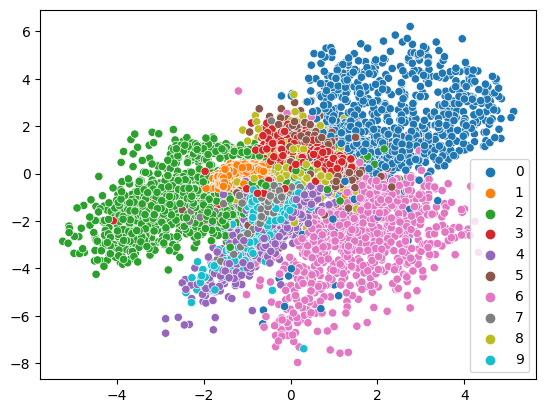

In [18]:
sns.scatterplot(
    x=projected[:,0],
    y=projected[:,1],
    hue=[str(l) for l in labels],
    hue_order=[str(i) for i in range(10)],
    legend="full")

In [19]:
def show_encode_decode(encode_decode,x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.inference_mode():
        x_recon = encode_decode(x.cpu())
        f , axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

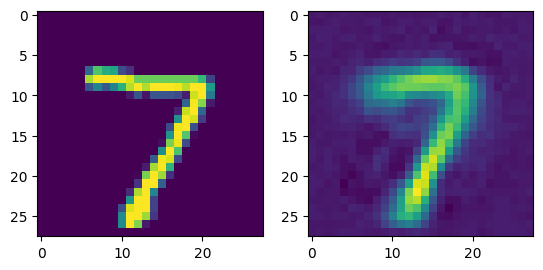

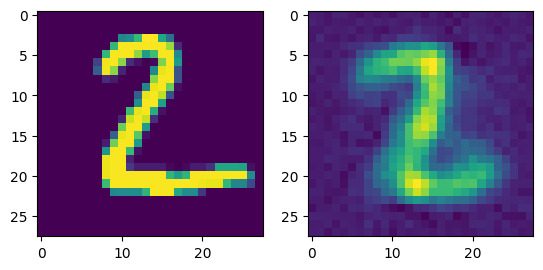

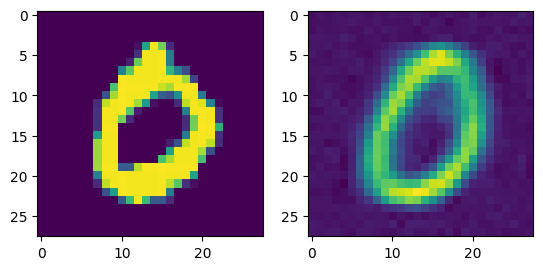

In [20]:
show_encode_decode(auto_encode_decode,test_data_xx[0][0])
show_encode_decode(auto_encode_decode,test_data_xx[1][0])
show_encode_decode(auto_encode_decode,test_data_xx[3][0])

## This part to add noise to a certain sample and see how the network works with that

In [21]:
# add noise function
normal = torch.distributions.Normal(0,0.5)
def addNoise(x,device='cpu'):
    """
    We will use this helper function to add noise to some data.
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on.
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

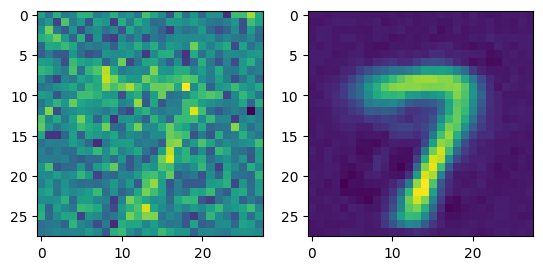

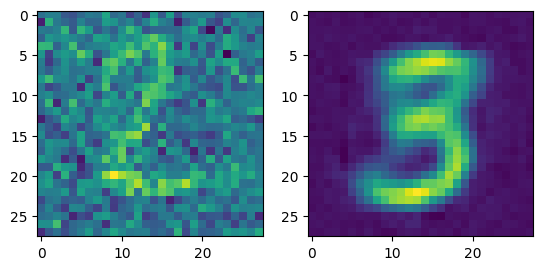

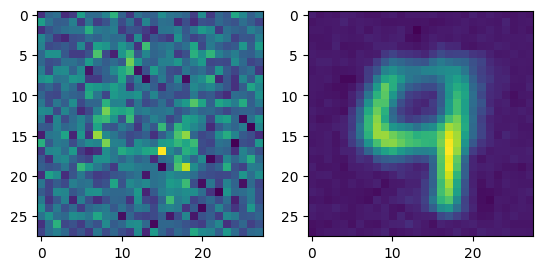

In [22]:
show_encode_decode(auto_encode_decode,addNoise(test_data_xy[0][0]))
show_encode_decode(auto_encode_decode,addNoise(test_data_xy[1][0]))
show_encode_decode(auto_encode_decode,addNoise(test_data_xy[4][0]))

## Denoising with Gaussian noise

first code we need is a new AdditiveGaussNoise layer. It takes the input x in. If we are in
training mode (denoted by self.training), we add noise to the input; otherwise we return it
unperturbed:

In [25]:
class AdditiveGaussNoise(nn.Module):
    def __init__(self):
        super(AdditiveGaussNoise, self).__init__()

    def forward(self,x:torch.Tensor):
# Every PyTorch Module object has a self.training boolean that can be used to check if we are in training (True) or evaluation (False) mode.    
        if self.training:              
            return addNoise(x,device=device)
        else:
            return x
            

## Now lets implment an autoencoder where instead of using bottlenck to downsize the feature `D//2` we simply double the feature `D*2`  

In [26]:
dn_auto_encoder_big = nn.Sequential(
    nn.Flatten(),
    AdditiveGaussNoise(),
    get_layer(D,D*2),
    get_layer(D*2,D*2),
    get_layer(D*2,D*2),
    nn.Linear(D*2,D*2)
)

dn_auto_decoder_big = nn.Sequential(
    get_layer(D*2,D*2),
    get_layer(D*2,D*2),
    get_layer(D*2,D*2),
    nn.Linear(D*2,D),
    View(-1,1,28,28)
)

In [27]:
dnauto_encode_decode_big = nn.Sequential(
    dn_auto_encoder_big,
    dn_auto_decoder_big
)

In [29]:
train_network(dnauto_encode_decode_big, loss_func=nn.MSELoss(),
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=3,
            device=device)

Epoch: 100%|██████████| 3/3 [00:40<00:00, 13.34s/it]


,epoch,total time,train loss,test loss
0,0,12.425837,0.027941,0.017871
1,1,24.392527,0.020798,0.014825
2,2,36.426358,0.018809,0.014210


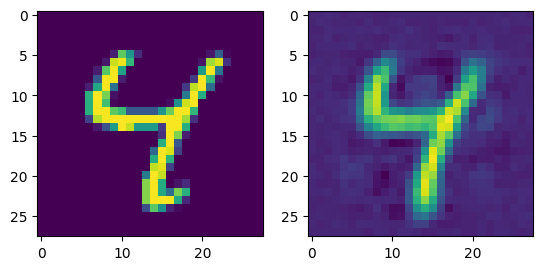

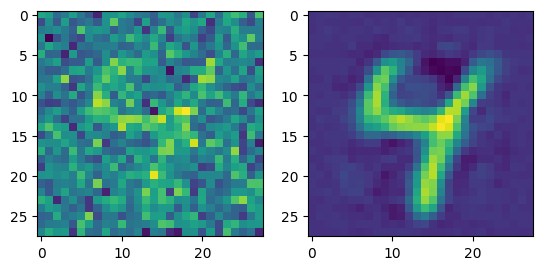

In [30]:
show_encode_decode(dnauto_encode_decode_big, test_data_xy[6][0])
show_encode_decode(dnauto_encode_decode_big, addNoise(test_data_xy[6][0]))

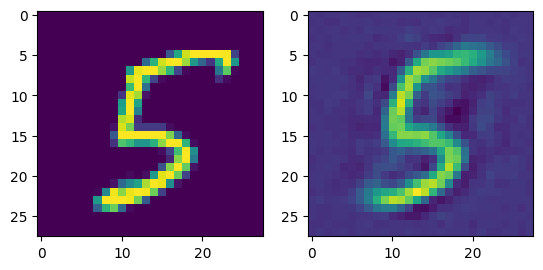

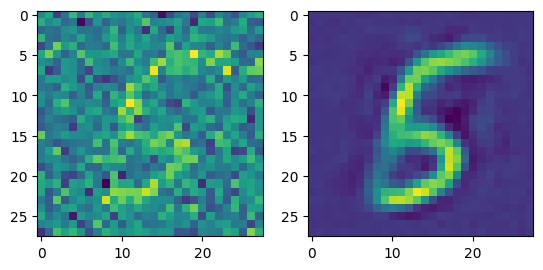

In [31]:
show_encode_decode(dnauto_encode_decode_big, test_data_xy[23][0])
show_encode_decode(dnauto_encode_decode_big, addNoise(test_data_xy[23][0]))

The denoising approach is very popular for training autoencoders, and the trick of introducing your
own perturbations into the data is widely used to build more accurate and robust models

# Now lets talk abour Denoising with Droupout

Adding Gaussian noise can be cumbersome because we need to figure out exactly how much noise to
add, which can change from dataset to dataset. A second, more popular approach is to use dropout.

Dropout is a very simple idea: with some probability p, zero out any given feature value. This forces
the network to be robust because it can never rely on any specific feature or neuron value.

Dropout is a very popular regularizer that can be
applied to both the input of a network and to the hidden layers.

In [32]:
dn_auto_encoder_dropout = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2),
    get_layer(D,D*2),
    nn.Dropout(),
    get_layer(D*2,D*2),
    nn.Dropout(),
    get_layer(D*2,D*2),
    nn.Dropout(),
    nn.Linear(D*2,D*2)
)

dn_auto_decoder_dropout = nn.Sequential(
    get_layer(D*2,D*2),
    nn.Dropout(),
    get_layer(D*2,D*2),
    nn.Dropout(),
    get_layer(D*2,D*2),
    nn.Dropout(),
    nn.Linear(D*2,D),
    View(-1,1,28,28)
)

In [33]:
dn_auto_encode_decode_dropout = nn.Sequential(
    dn_auto_encoder_dropout,
    dn_auto_decoder_dropout
)

In [35]:
train_network(dn_auto_encode_decode_dropout, loss_func=nn.MSELoss(),
            train_loader=train_loader, test_loader=test_loader, epochs=4, device=device)

Epoch: 100%|██████████| 4/4 [00:53<00:00, 13.36s/it]


,epoch,total time,train loss,test loss
0,0,12.308398,0.044342,0.030415
1,1,24.053797,0.035072,0.026430
2,2,36.078121,0.032547,0.023963
3,3,48.210611,0.030777,0.022695


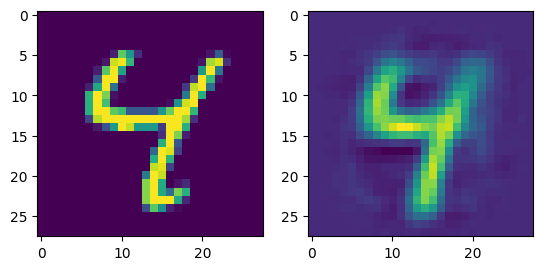

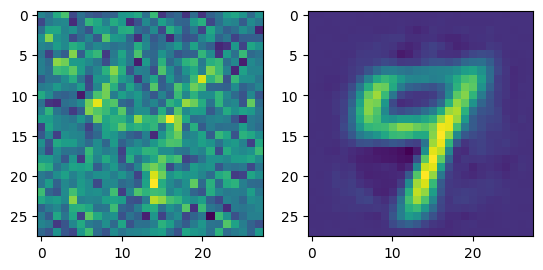

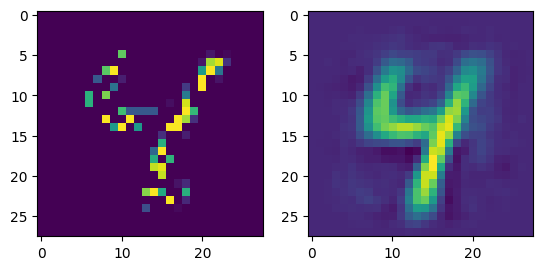

In [38]:
# x input and output with dropout 
show_encode_decode(dn_auto_encode_decode_dropout,test_data_xy[6][0])
# # x input and output with noise introduced to x input and the network still figures out the output
show_encode_decode(dn_auto_encode_decode_dropout,addNoise(test_data_xy[6][0]))
# # x input and output with dropout applied to x input 
show_encode_decode(dn_auto_encode_decode_dropout,nn.Dropout()(test_data_xy[6][0]))